# Evaluate models results

In this notebook, we're going to evaluate the models results. We have three models: heuristic, decision tree and random forest. 

- Heuristic: Apply a business rule: approves a loan if the `total_amount` request is lower than `sum_amt_transactions_in_last_month`.
- Decision tree: Uses the features in `df_loans_with_loans_repays_hist_and_trans_hist_per_user_cleared.csv` and apply the decision tree.
- Random forest: Uses the features in `df_loans_with_loans_repays_hist_and_trans_hist_per_user_cleared.csv` apply random forest.



Let's check the gain of each model in relation to f1-score, precision,recall and AUC, revenue gains and losses and find out the impact of the features chosen on the optimized model.

In [1]:
import os
os.chdir("../")

In [2]:
import pandas as pd
from pandas.tseries.offsets import DateOffset
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import yaml
import shap

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve,roc_auc_score,precision_recall_fscore_support
from sklearn.impute import SimpleImputer
from typing import Union
from helper import *
from src.features import *
from src.models import make_predict
from src.data.data_cleaning import make_pipeline,convert_to_date,convert_to_datetime,calculate_interest_rate

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## 2 - Data reading

In [3]:
train_data = pd.read_csv("./data/processed/train_data.csv")
test_data = pd.read_csv("./data/processed/test_data.csv")


list_functions = [
    {"function": convert_to_datetime, "function_kwargs": {
        "col_to_convert":"created_at",
        "fmt":"ISO8601"
    }},
    {"function": convert_to_date, "function_kwargs": {
        "col_to_convert":"due_date",
        "fmt":"%Y-%m-%d"
    }},
    {"function": convert_to_date, "function_kwargs": {
        "col_to_convert":"date_created",
        "fmt":"%Y-%m-%d"
    }},
    {"function": convert_to_date, "function_kwargs": {
        "col_to_convert":"reference_date",
        "fmt":"%Y-%m-%d"
    }},
]

## select only repaid and debt loans
train_data = make_pipeline(dataframe=train_data,functions=list_functions)
test_data = make_pipeline(dataframe=test_data,functions=list_functions)

## columns check
print(set(train_data.columns)==set(test_data.columns))

True


## 2 - Data preprocessing

In [4]:
TARGET = "status"
NUM_FEATURES = list(train_data.select_dtypes(include=["float64"],exclude=["object","int64"]).columns)
CAT_FEATURES = [col for col in list(train_data.select_dtypes(include=["object"],exclude=["float64","int64"]).columns)
                if col not in ["date_created","reference_date","created_at","due_date",TARGET]]
FEATURES = NUM_FEATURES + CAT_FEATURES
FEATURES

['amount',
 'total_amount',
 'due_amount',
 'sum_amt_transactions_at_created_loan',
 'sum_amt_payment_method_credit_at_created_loan',
 'sum_amt_payment_method_debit_at_created_loan',
 'sum_amt_transactions_in_visa_at_created_loan',
 'sum_amt_transactions_in_mastercard_at_created_loan',
 'sum_amt_transactions_in_elo_at_created_loan',
 'max_amt_transactions_at_created_loan',
 'max_installments_at_created_loan',
 'median_installments_at_created_loan',
 'sum_amt_transactions_in_last_month',
 'sum_amt_payment_method_credit_in_last_month',
 'sum_amt_payment_method_debit_in_last_month',
 'sum_amt_transactions_in_visa_in_last_month',
 'sum_amt_transactions_in_mastercard_in_last_month',
 'sum_amt_transactions_in_elo_in_last_month',
 'max_amt_transactions_in_last_month',
 'max_installments_in_last_month',
 'median_installments_in_last_month',
 'avg_amt_transactions_in_last_three_months',
 'avg_amt_payment_method_credit_in_last_three_months',
 'avg_amt_payment_method_debit_in_last_three_months',


In [5]:
X_train = train_data[NUM_FEATURES+CAT_FEATURES]
y_train = train_data[TARGET].map({"repaid":1,"debt":0})
X_test = test_data[NUM_FEATURES+CAT_FEATURES]
y_test = test_data[TARGET].map({"repaid":1,"debt":0})

print("X_train, y_train shape:",(X_train.shape,y_train.shape))
print("X_test, y_test:",(X_test.shape,y_test.shape))
print("y_train proportion of repay and debt:",y_train.value_counts(normalize=True))
print("y_test proportion of repay and debt:",y_test.value_counts(normalize=True))

X_train, y_train shape: ((5963, 69), (5963,))
X_test, y_test: ((769, 69), (769,))
y_train proportion of repay and debt: status
1    0.741908
0    0.258092
Name: proportion, dtype: float64
y_test proportion of repay and debt: status
1    0.811443
0    0.188557
Name: proportion, dtype: float64


## 3 - Apply predictions for models

In [6]:
# carregando parametros dos modelos 

with open("./config/decision_tree_clf_for_loan_repaymnt_pred_config.yaml","r") as dt_config_f:
    cfg_dt = yaml.safe_load(dt_config_f)

with open("./config/random_forest_clf_for_loan_repaymnt_with_fs_config.yaml","r") as rf_config_f:
    cfg_rf = yaml.safe_load(rf_config_f)

In [7]:
# construindo pipelines

## get features
DT_CAT_FEATURES = [col.decode(encoding="ISO-8859-1") for col in cfg_dt["model_features"]["CAT_FEATURES"]]
DT_NUM_FEATURES = [col.decode(encoding="ISO-8859-1") for col in cfg_dt["model_features"]["NUM_FEATURES"]]

RF_CAT_FEATURES = [col.decode(encoding="ISO-8859-1") for col in cfg_rf["model_features"]["CAT_FEATURES"]]
RF_NUM_FEATURES = [col.decode(encoding="ISO-8859-1") for col in cfg_rf["model_features"]["NUM_FEATURES"]]


categorical_transformer = Pipeline(
    steps=[
        ('cat_imputer',SimpleImputer(strategy="most_frequent")),
        ('ohe_cat', OneHotEncoder())
        ]
)


## construct preprocessors
dt_preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), DT_NUM_FEATURES),
        ('cat', categorical_transformer, DT_CAT_FEATURES)])

rf_preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), RF_NUM_FEATURES),
        ('cat', categorical_transformer, RF_CAT_FEATURES)])

## use feature selection for random forest 
arr_selected_features = cfg_rf["model_parameters"]["fs_params"]["select_cols_arr"]
col_selector = ColumnTransformer(
    transformers=[("select_cols","passthrough",arr_selected_features)]
)

# Define the pipelines
dt_pipeline = Pipeline(steps=[
    ('preprocessor', dt_preprocessor),  # Preprocessing (imputation + one-hot encoding)
    ('model',DecisionTreeClassifier(**cfg_dt["model_parameters"]["fit_params"]))  # Model
])
rf_pipeline = Pipeline(steps=[
    ('preprocessor', rf_preprocessor),  # Preprocessing (imputation + one-hot encoding),
    ("select_cols",col_selector),
    ('model', RandomForestClassifier(**cfg_rf["model_parameters"]["fit_params"]))  # Model
])

In [8]:
## FIT THE MODELS 
dt_model = dt_pipeline.fit(X_train,y_train)
rf_model = rf_pipeline.fit(X_train,y_train)

In [9]:
heuristic_predict = ((X_test["total_amount"]>X_test["sum_amt_transactions_in_last_month"])).map({False:1,True:0})

dt_y_pred_proba,dt_y_pred = make_predict(model=dt_model,X_test=X_test,return_classes=True)

BEST_TH_RF = cfg_rf["model_parameters"]["predict_params"]["decision_threshold"]
rf_y_pred_proba,rf_y_pred = make_predict(X_test=X_test,model=rf_model,return_classes=True,threshold=BEST_TH_RF)

## 4 - Analysis

Once the models have been loaded, we will now evaluate the results

### 4.1 - Compare f1-score, precision, recall and ROC AUC

In [10]:
all_preds = {"random_forest":rf_y_pred,"decision_tree":dt_y_pred,"heuristic":heuristic_predict}
all_metrics = {model:precision_recall_fscore_support(y_test,y_pred,average="weighted")
               for model,y_pred in all_preds.items()}
df_all_metrics = pd.DataFrame.from_dict(all_metrics)
df_all_metrics = df_all_metrics.drop(index=3)
df_all_metrics.index = ["weighted avg precision","weighted avg recall","weighted avg f1-score"]

,weighted avg precision,weighted avg recall,weighted avg f1-score
random_forest,0.80,0.74,0.76
decision_tree,0.73,0.73,0.73
heuristic,0.77,0.79,0.77


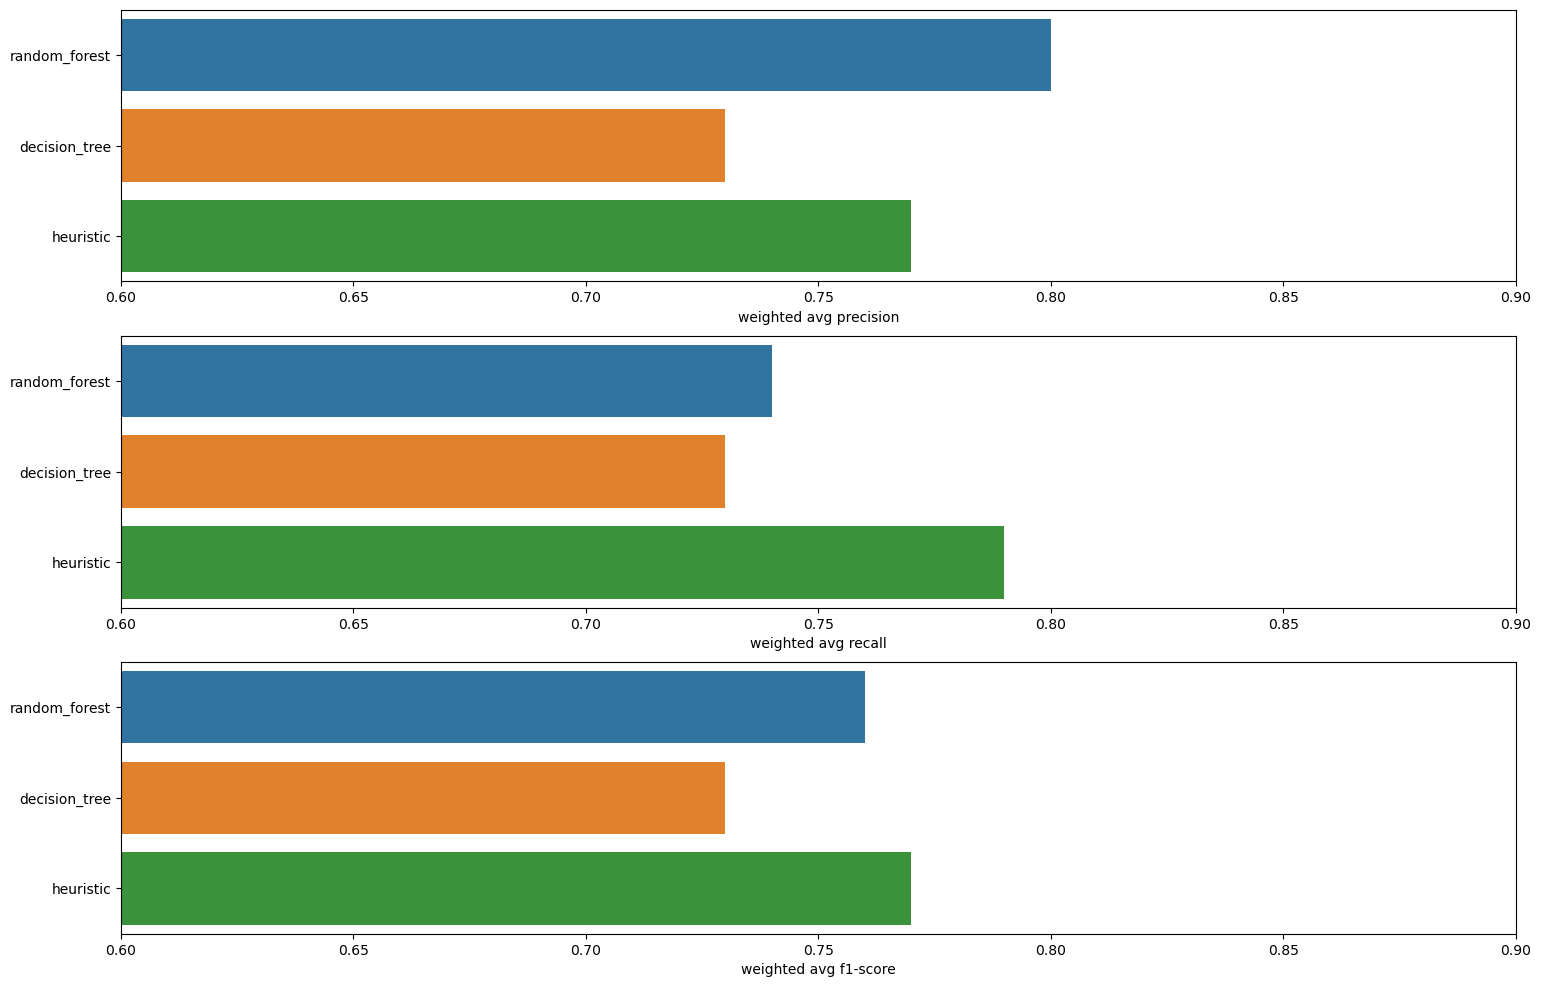

In [11]:
fig,axes = plt.subplots(3,1,figsize=(18,12))
df_all_metrics = df_all_metrics.transpose()
df_all_metrics = df_all_metrics.apply(func=lambda d: np.round(d,2),axis=1)
for col,ax in zip(df_all_metrics.columns,axes):
   p = sns.barplot(data=df_all_metrics,y=df_all_metrics.index,x=col,ax=ax);
   p.set_xlim([0.6,0.9])
df_all_metrics

Regarding metrics, we see that the random forest performed better than the decision tree and had a similar performance to the heuristic model. In percentages, the weighted metrics obtained:
- The precision for the random forest achieved a gain of 9.6% for the heuristic model and 4% for the decision tree.
- Recall decreased by 6.3% in relation to the heuristic model and 1.3% in relation to the decision tree.
- Regarding the f1-score, we have a 4% gain compared to the decision tree and a 1.3% loss compared to the heuristic model.

The random forest and the heuristic model obtained similar results, especially when viewing the weighted f1-score, even so, it had better precision performance when compared to other models, that is, it identified fewer false positives. Given our problem of classifying loan payments is the second metric to compare, lower false positive values mean fewer defaulting customers and greater gains in interest and fees for the company. Let's see the ROC curve

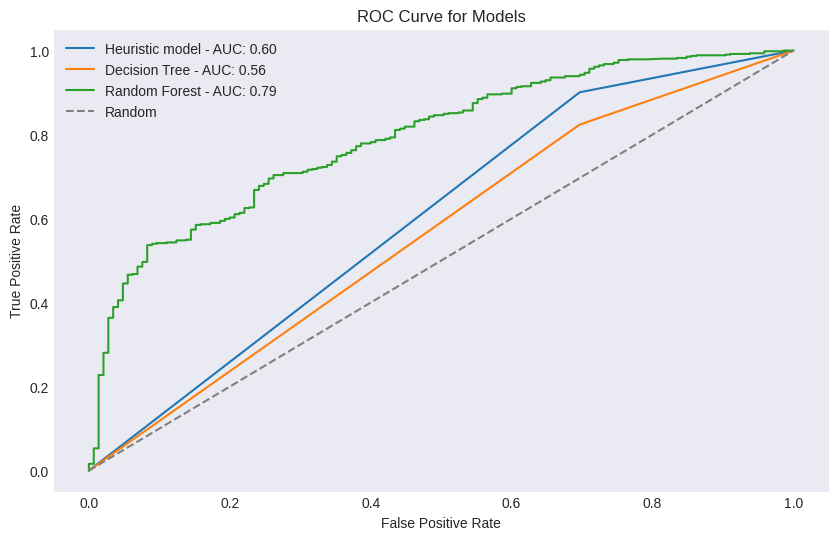

In [12]:
# Calculate ROC curve and ROC AUC score for each model
fpr_model_heuristic, tpr_model_heuristic, _ = roc_curve(y_test, heuristic_predict)
roc_auc_model_heuristic= roc_auc_score(y_test, heuristic_predict)

fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_y_pred)
roc_auc_model_dt = roc_auc_score(y_test, dt_y_pred_proba)

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_y_pred_proba)
roc_auc_model_rf = roc_auc_score(y_test, rf_y_pred_proba)

# Create a plot
plt.style.use("seaborn-v0_8-dark")
plt.figure(figsize=(10, 6))
plt.plot(fpr_model_heuristic, tpr_model_heuristic, label=f"Heuristic model - AUC: {roc_auc_model_heuristic:.2f}")
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree - AUC: {roc_auc_model_dt:.2f}")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest - AUC: {roc_auc_model_rf:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Models")
plt.legend()
plt.show()

Seeing the ROC curve we see that the best AUC is for the random forest model even for diferent types of false positive rates we see that the random forest have significant better performance that the other models.

## 4.2 - Total revenue gain assessment of the optimized model

To evaluate how much revenue each model generated, we will evaluate two cases:
  - Gain from loan repaid adjustments: The case in which the model correctly predicted the payment of the loan. In this case we earned interest and fees on the amount borrowed.
  - Gain in relation to false negatives: This is the case in which the model does not predict payment of the loan but it occurs. This is a case in which interest and fees are earned again.

In [13]:
df_loans_repay_hist = pd.read_csv("./data/processed/loans_repayment_history_features.csv")
df_loans_repay_hist = make_pipeline(dataframe=df_loans_repay_hist,functions=list_functions[:3]) #here don't need reference_date
test_data_with_preds = test_data.copy()
test_data_with_preds["dt_y_pred"] = dt_y_pred
test_data_with_preds["rf_y_pred"] = rf_y_pred
test_data_with_preds["heuristic_y_pred"] = heuristic_predict

In [14]:
all_gains_rf = test_data_with_preds[((test_data_with_preds["status"]=="repaid")&(test_data_with_preds["rf_y_pred"]==1))|
                                    ((test_data_with_preds["status"]=="repaid")&(test_data_with_preds["rf_y_pred"]==0))].copy()

all_gains_rf = all_gains_rf.merge(
    how="inner",
    right=df_loans_repay_hist.set_index(["id","date_created","due_date"])["amt_paid_till_trd_month"],
    right_index=True,
    left_on=["id","date_created","due_date"]
)

all_gains_dt = test_data_with_preds[((test_data_with_preds["status"]=="repaid")&(test_data_with_preds["dt_y_pred"]==1))|
                                    ((test_data_with_preds["status"]=="repaid")&(test_data_with_preds["dt_y_pred"]==0))].copy()

all_gains_dt = all_gains_dt.merge(
    how="inner",
    right=df_loans_repay_hist.set_index(["id","date_created","due_date"])["amt_paid_till_trd_month"],
    right_index=True,
    left_on=["id","date_created","due_date"]
)

all_gains_heuristic = test_data_with_preds[((test_data_with_preds["status"]=="repaid")&(test_data_with_preds["heuristic_y_pred"]==1))|
                                    ((test_data_with_preds["status"]=="repaid")&(test_data_with_preds["heuristic_y_pred"]==0))].copy()

all_gains_heuristic = all_gains_heuristic.merge(
    how="inner",
    right=df_loans_repay_hist.set_index(["id","date_created","due_date"])["amt_paid_till_trd_month"],
    right_index=True,
    left_on=["id","date_created","due_date"]
)

df_all_gain_metrics = pd.DataFrame(
    data={
        "models": ["random_forest","decision_tree","heuristic"],
        "sum_gains":[all_gains_rf["amt_paid_till_trd_month"].sum(),
                         all_gains_dt["amt_paid_till_trd_month"].sum(),
                         all_gains_heuristic["amt_paid_till_trd_month"].sum()],
        "sum_true_positive_gains":[
            all_gains_rf[(all_gains_rf["status"]=="repaid")\
                                 &(all_gains_rf["rf_y_pred"]==1)]["amt_paid_till_trd_month"].sum(),
            all_gains_dt[(all_gains_dt["status"]=="repaid")\
                                 &(all_gains_dt["dt_y_pred"]==1)]["amt_paid_till_trd_month"].sum(),
            all_gains_heuristic[(all_gains_heuristic["status"]=="repaid")\
                                 &(all_gains_heuristic["heuristic_y_pred"]==1)]["amt_paid_till_trd_month"].sum()
        ],
         "sum_false_negative_gains":[
            all_gains_rf[(all_gains_rf["status"]=="repaid")\
                                 &(all_gains_rf["rf_y_pred"]==0)]["amt_paid_till_trd_month"].sum(),
            all_gains_dt[(all_gains_dt["status"]=="repaid")\
                                 &(all_gains_dt["dt_y_pred"]==0)]["amt_paid_till_trd_month"].sum(),
            all_gains_heuristic[(all_gains_heuristic["status"]=="repaid")\
                                 &(all_gains_heuristic["heuristic_y_pred"]==0)]["amt_paid_till_trd_month"].sum()
        ]        
    },
)

df_all_gain_metrics["pct_gains_true_positive"]=(df_all_gain_metrics["sum_true_positive_gains"]/df_all_gain_metrics["sum_gains"])*100.0
df_all_gain_metrics["pct_gains_false_negative"]=(df_all_gain_metrics["sum_false_negative_gains"]/df_all_gain_metrics["sum_gains"])*100.0

df_all_gain_metrics = df_all_gain_metrics.apply(lambda d: np.round(d,2),axis=1)

,models,sum_gains,sum_true_positive_gains,sum_false_negative_gains,pct_gains_true_positive,pct_gains_false_negative
0,random_forest,3711891.18,2815946.08,895945.10,75.862840,24.137160
1,decision_tree,3711891.18,3040525.29,671365.89,81.913104,18.086896
2,heuristic,3711891.18,3355973.39,355917.79,90.411416,9.588584


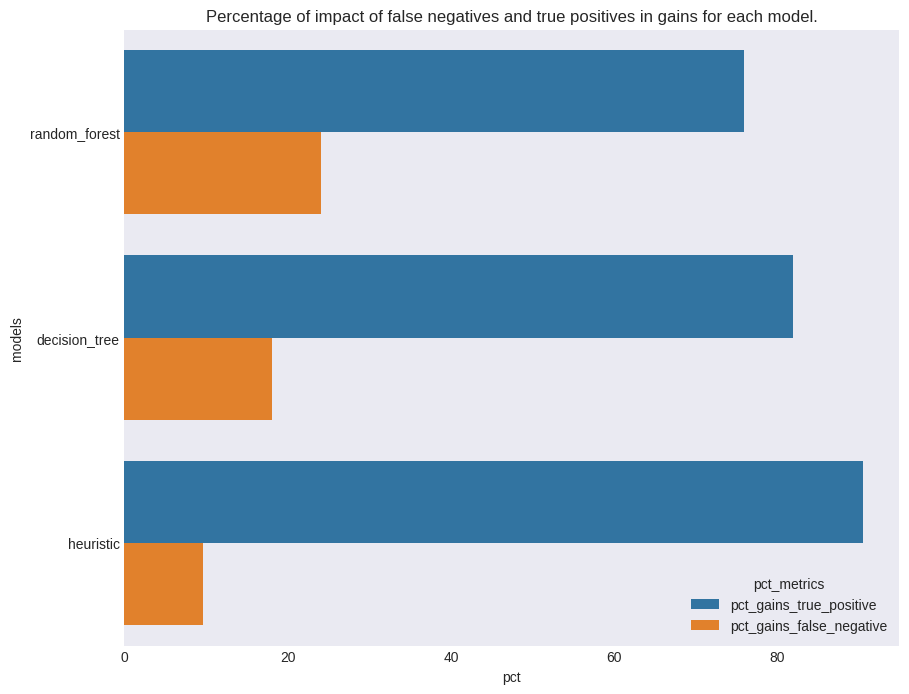

In [15]:
pcts_gain_metrics = df_all_gain_metrics[["models","pct_gains_true_positive","pct_gains_false_negative"]].copy()

df_all_gain_metrics_melt = pd.melt(pcts_gain_metrics,id_vars="models",var_name="pct_metrics",value_name="pct")

fig,ax = plt.subplots(figsize=(10,8))
sns.barplot(data=df_all_gain_metrics_melt,y="models",x="pct",hue="pct_metrics")
plt.title(f"Percentage of impact of false negatives and true positives in gains for each model.");
df_all_gain_metrics

To consider the gain of the models we need to evaluate both the number of loans that were correctly predicted as they indicate the value of gain expected by the model and also the false negatives as these indicate an additional gain as they are loans that were expected not to be paid. In this way, we see both models present the same expected gain value, with the heuristic model being the one that presented the greatest gain with true positives.

## 4.3 - Evaluating model losses

Model losses are calculated from false positives. This is the case in which payment of the loan is expected and it does not occur.

To do this, we will consider two scenarios:
- Worst scenario: where all customers do not pay any of the `total_amount`. The debt amount is given by `due_amount`.
- Real scenario: where some customers pay part of the `total_amount` value. In this case, the value of interest accrued on the amounts over the months from the creation of the loan to the `due_date` is calculated based on the interest rate when the loan was created.

In [17]:
def calculate_amount_defaulted(dataframe:pd.DataFrame)->pd.DataFrame:
    """
     Calculate the amount defaulted of a loan considering their monthly interest rate.

     Args:
         dataframe (pd.DataFrame): Input DataFrame containing loan information.

     Returns:
         pd.DataFrame: DataFrame with added column 'total_amount_defaulted' representing the total amount defaulted.
     
    """    
    new_df = dataframe.copy()
    new_df = make_pipeline(dataframe=new_df,functions=[{"function":calculate_interest_rate}])
    
    new_df["end_of_first_month"] = [pd.date_range(start=d,end=d+DateOffset(months=1),freq="ME")[0] for d in new_df["date_created"]]
    new_df["end_of_sec_month"] = [pd.date_range(start=d,end=d+DateOffset(months=2),freq="ME")[-1] for d in new_df["date_created"]]
    
    new_df = new_df.merge(
        how="inner",
        right=df_loans_repay_hist.set_index(["id","date_created","due_date"])[["amt_paid_first_month",
                                                                               "amt_paid_sec_month",
                                                                               "amt_paid_third_month"]],
       right_index=True,
       left_on=["id","date_created","due_date"]
       )

    new_df["amt_paid_first_month"] = new_df["amt_paid_first_month"].fillna(value=0.0)
    new_df["amt_paid_sec_month"] = new_df["amt_paid_sec_month"].fillna(value=0.0)
    new_df["amt_paid_third_month"] = new_df["amt_paid_third_month"].fillna(value=0.0)


    new_df['time_years_first_month'] = [
         (end_date.date()-date_created).days/365 for date_created,end_date in new_df[["date_created","end_of_first_month"]].values
         ]
    new_df['time_years_sec_month'] = [
         (end_date.date() - date_created).days/365 for date_created,end_date in new_df[["date_created","end_of_sec_month"]].values
         ]
    new_df['time_years_trd_month'] = [
         (end_date - date_created).days/365 for date_created,end_date in new_df[["date_created","due_date"]].values
      ]

    new_df["total_amt_to_repaid_to_sec_month"] = new_df['total_amount']-new_df["amt_paid_first_month"]
    new_df["total_amt_to_repaid_to_trd_month"] = new_df['total_amt_to_repaid_to_sec_month']-new_df["amt_paid_sec_month"]
    new_df["total_amt_to_repaid_to_due_date"] = new_df['total_amt_to_repaid_to_trd_month']-new_df["amt_paid_third_month"]


    new_df['accrued_interest_first_month'] = (new_df['total_amt_to_repaid_to_sec_month'] * (new_df['monthly_interest_rate'] / 100)) * (new_df["time_years_first_month"])
    new_df['accrued_interest_sec_month'] = (new_df["total_amt_to_repaid_to_trd_month"] * (new_df['monthly_interest_rate'] / 100)) * (new_df["time_years_sec_month"])
    new_df['accrued_interest_trd_month'] = (new_df["total_amt_to_repaid_to_due_date"]* (new_df['monthly_interest_rate'] / 100)) * (new_df["time_years_trd_month"])

    new_df["total_amount_defaulted"] = new_df["total_amt_to_repaid_to_due_date"] + new_df['accrued_interest_trd_month']

    return new_df[["id","date_created","due_date","total_amount_defaulted"]].copy()

In [18]:
all_loses_rf = test_data_with_preds[((test_data_with_preds["status"]=="debt")&(test_data_with_preds["rf_y_pred"]==1))].copy()


all_loses_dt = test_data_with_preds[((test_data_with_preds["status"]=="debt")&(test_data_with_preds["dt_y_pred"]==1))].copy()

all_loses_heuristic = test_data_with_preds[((test_data_with_preds["status"]=="debt")&(test_data_with_preds["heuristic_y_pred"]==1))].copy()


df_all_loses_metrics_worst_case = pd.DataFrame(
    data={
        "sum_losses_in_worst_sce":[all_loses_rf["due_amount"].sum(),
                         all_loses_dt["due_amount"].sum(),
                         all_loses_heuristic["due_amount"].sum()],             
    },
    index=["random_forest","decision_tree","heuristic"]
)

df_rf_total_amt_defaulted = calculate_amount_defaulted(dataframe=all_loses_rf)
df_dt_total_amt_defaulted = calculate_amount_defaulted(dataframe=all_loses_dt)
df_heuristic_total_amt_defaulted = calculate_amount_defaulted(dataframe=all_loses_heuristic)

,models,sum_losses_in_worst_sce,sum_losses_in_real_sce
0,random_forest,389690.70,157078.40
1,decision_tree,727073.54,345337.71
2,heuristic,748453.10,355921.41


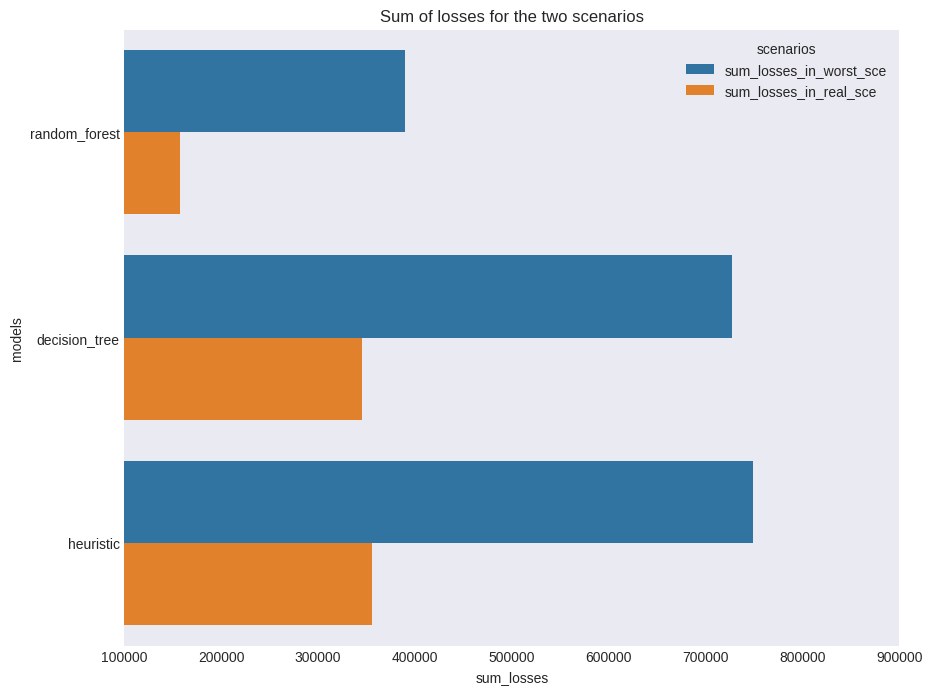

In [19]:
df_all_defaulted_loans = pd.DataFrame(
    data={
        "sum_losses_in_real_sce":[df_rf_total_amt_defaulted["total_amount_defaulted"].sum(),
                         df_dt_total_amt_defaulted["total_amount_defaulted"].sum(),
                         df_heuristic_total_amt_defaulted["total_amount_defaulted"].sum()],             
    },
    index=["random_forest","decision_tree","heuristic"]
)

df_all_losses_metrics = df_all_loses_metrics_worst_case.join(
    other=df_all_defaulted_loans,
    how="inner"
)

df_all_losses_metrics = df_all_losses_metrics.apply(func=lambda d: np.round(d,2),axis=1)
df_all_losses_metrics = df_all_losses_metrics.reset_index(names="models")

df_all_losses_metrics_melt = pd.melt(df_all_losses_metrics,id_vars="models",var_name="scenarios",value_name="sum_losses")

fig,ax = plt.subplots(figsize=(10,8))
sns.barplot(data=df_all_losses_metrics_melt,y="models",x="sum_losses",hue="scenarios",ax=ax)
plt.title("Sum of losses for the two scenarios");
ax.set_xlim([100000.0,900000.0])
df_all_losses_metrics

,models,scenarios,pct_between_sum_losses_and_gains
0,random_forest,worst_scenario,10.50
1,decision_tree,worst_scenario,19.59
2,heuristic,worst_scenario,20.16
3,random_forest,real_scenario,4.23
4,decision_tree,real_scenario,9.30
5,heuristic,real_scenario,9.59


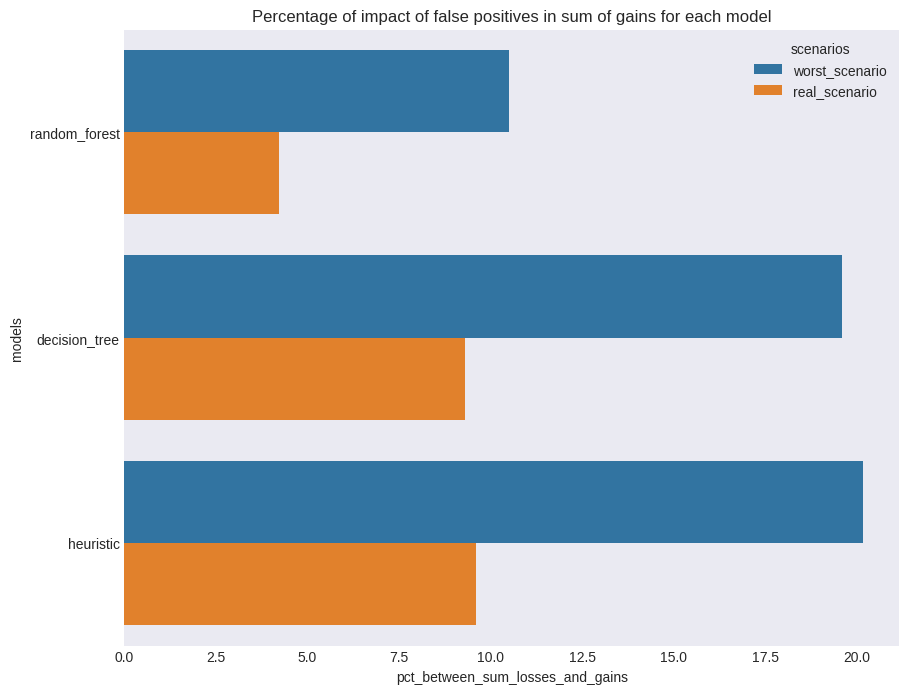

In [20]:
dict_pct_between_sum_losses_gains = {
    "worst_scenario":{model: (df_all_losses_metrics[df_all_losses_metrics["models"]==model]["sum_losses_in_worst_sce"]
    /df_all_gain_metrics[df_all_gain_metrics["models"]==model]["sum_gains"]).to_list()[0]
    for model in ["random_forest","decision_tree","heuristic"]},
    "real_scenario":{model: (df_all_losses_metrics[df_all_losses_metrics["models"]==model]["sum_losses_in_real_sce"]
    /df_all_gain_metrics[df_all_gain_metrics["models"]==model]["sum_gains"]).to_list()[0]
    for model in ["random_forest","decision_tree","heuristic"]}
}

df_pct_between_sum_losses_and_gains = pd.DataFrame.from_dict(data=dict_pct_between_sum_losses_gains)
df_pct_between_sum_losses_and_gains = df_pct_between_sum_losses_and_gains.apply(lambda d:np.round(100.0*d,2),axis=1)
df_pct_between_sum_losses_and_gains = df_pct_between_sum_losses_and_gains.reset_index(names="models")
df_pct_between_sum_losses_and_gains_m  = pd.melt(frame=df_pct_between_sum_losses_and_gains,id_vars="models",var_name="scenarios",
                                               value_name="pct_between_sum_losses_and_gains")
fig,ax = plt.subplots(figsize=(10,8))
sns.barplot(data=df_pct_between_sum_losses_and_gains_m,y="models",x="pct_between_sum_losses_and_gains",hue="scenarios",ax=ax)
plt.title("Percentage of impact of false positives in sum of gains for each model");
df_pct_between_sum_losses_and_gains_m

The random forest presented the lowest loss compared to the baseline models, considering the worst case scenario we have 46.4% less loss compared to the decision tree and 47.9% less compared to the heuristic model, in the real scenario we have 54.5% less loss in relation to the decision tree and 55.9% less in relation to the heuristic model. Precisely because it has the highest precision among the baseline models.

One importance thing to notice is that in second chart we see that comparing the sum of losses and sum of gains (ratio between sum of losses and sum of gains) considering the two scenarios we see that that the random forest model have the least percentage of lost of gain, its loss only represents 10.5% of the overall obtained in the worst scenario and 4.2% for the real secnario. Let's see how much we can get subtracting the losses from the gains obtained.

,models,total_gains_worst_scenario,total_gains_real_scenario,pct_performance_in_worst_sce,pct_performance_in_real_sce
0,random_forest,3322200.48,3554812.78,89.501559,95.768238
1,decision_tree,2984817.64,3366553.47,80.412315,90.696448
2,heuristic,2963438.08,3355969.77,79.836340,90.411319


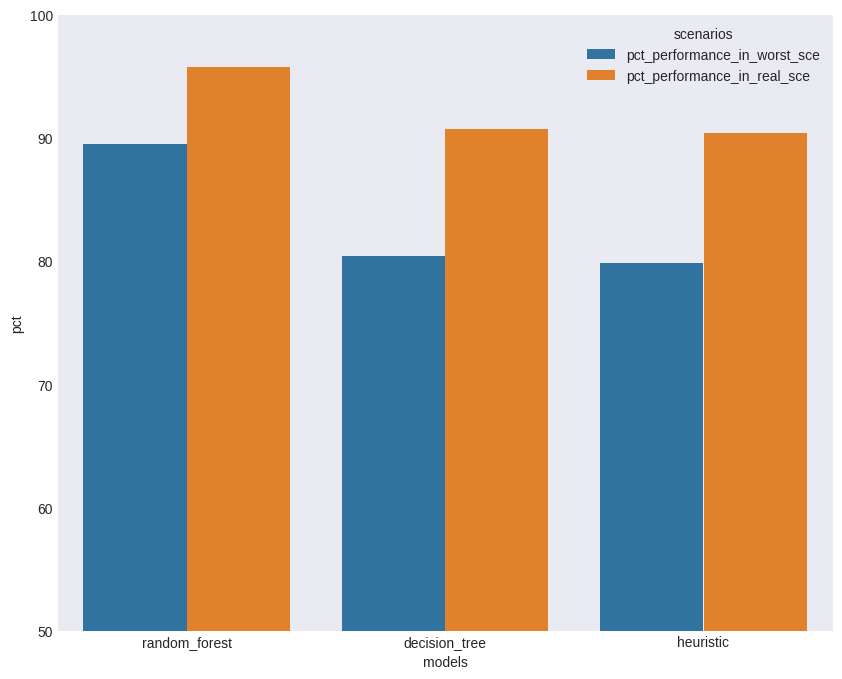

In [21]:
dict_balanc_between_sum_losses_gains = {
    "total_gains_worst_scenario":{model: (df_all_gain_metrics[df_all_gain_metrics["models"]==model]["sum_gains"] - 
                      df_all_losses_metrics[df_all_losses_metrics["models"]==model]["sum_losses_in_worst_sce"]).to_list()[0]
    for model in ["random_forest","decision_tree","heuristic"]},
    "total_gains_real_scenario":{model: (df_all_gain_metrics[df_all_gain_metrics["models"]==model]["sum_gains"] - 
                      df_all_losses_metrics[df_all_losses_metrics["models"]==model]["sum_losses_in_real_sce"]).to_list()[0]
    for model in ["random_forest","decision_tree","heuristic"]}
}


df_balanc_general = pd.DataFrame.from_dict(dict_balanc_between_sum_losses_gains)
df_balanc_general = df_balanc_general.reset_index(names="models")

df_balanc_general["pct_performance_in_worst_sce"] = (df_balanc_general["total_gains_worst_scenario"]/df_all_gain_metrics["sum_gains"])*100.0
df_balanc_general["pct_performance_in_real_sce"] = (df_balanc_general["total_gains_real_scenario"]/df_all_gain_metrics["sum_gains"])*100.0

df_balanc_general = df_balanc_general.apply(lambda d: np.round(d,2),axis=1)

df_balanc_general_m = pd.melt(frame=df_balanc_general[["models","pct_performance_in_worst_sce","pct_performance_in_real_sce"]],
                              id_vars="models",var_name="scenarios",value_name="pct")

fig,ax = plt.subplots(figsize=(10,8))
sns.barplot(data=df_balanc_general_m,x="models",y="pct",hue="scenarios",ax=ax)
ax.set_ylim([50.0,100.0])
df_balanc_general

As we can analyze, discounting the losses, we see that the random forest model had the greatest total gain when compared to the model with decision tree and heuristic. Considering the worst case scenario, the random forest model had 11.3% more gain than the decision tree and 12.1% more than the heuristic model, whereas in the real case the random forest model had 5.6% more gain than the decision tree and 5.9% more than the heuristic model.

Also, this information confirms what we saw in the chart comparing the ratios above, the random forest it's the model that we least lose gains. This means that we can preserve in worst scenario 89.5% of the gains obtained and about 95.8% in the real scenario.

## 5 - Evaluating features importances

As a last parameter for analysis, we will evaluate the importance of the random forest features. For this, SHAP will be used, which is a graph that shows the most important features for the model and considering the impact that a change in the feature's value generates on the model's output.

In [22]:
X_train_rf_t = rf_model.named_steps["preprocessor"].transform(X_train)
X_train_rf_t = rf_model.named_steps["select_cols"].transform(X_train_rf_t)
output_feature_names = rf_model.named_steps["preprocessor"].get_feature_names_out()[arr_selected_features]
shap_values = shap.explainers.Tree(rf_model.named_steps["model"]).shap_values(X_train_rf_t)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


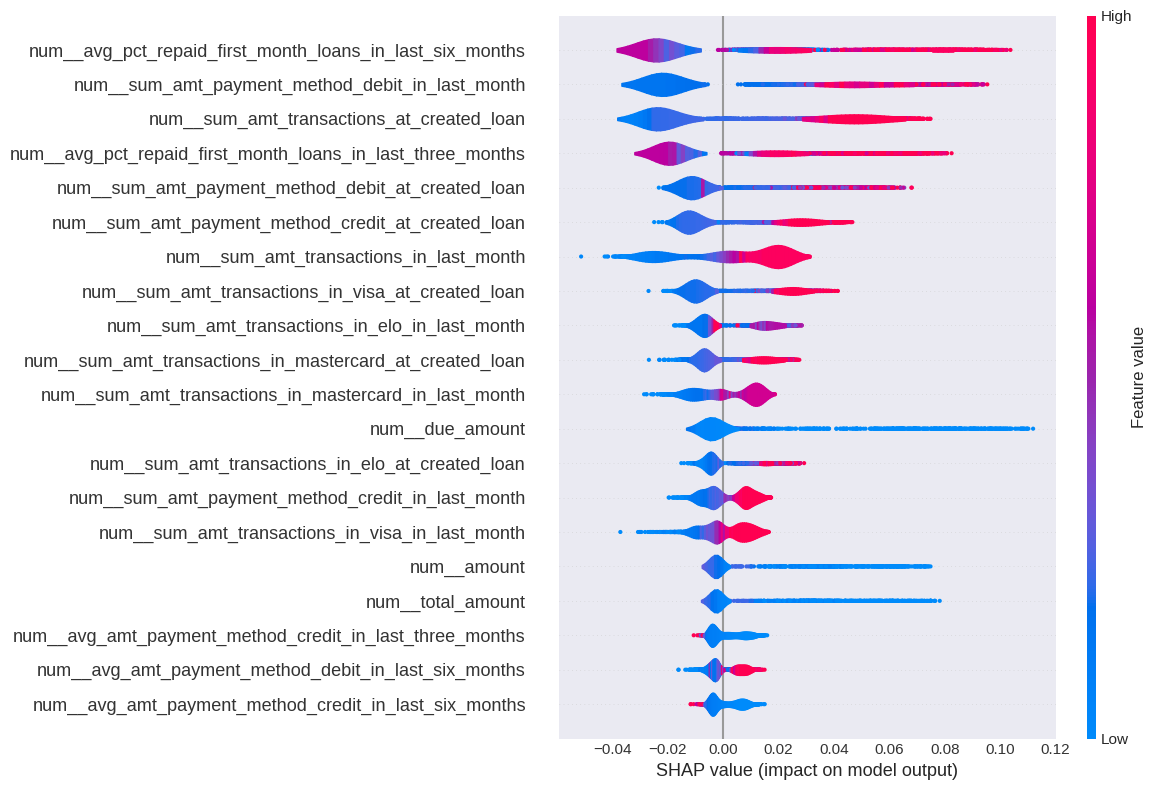

In [23]:
df_X_train_rf_t = pd.DataFrame(X_train_rf_t,columns=output_feature_names)
shap.summary_plot(shap_values[1],df_X_train_rf_t,plot_size=(12.0,8.0),plot_type="violin")

Through shap we see some interesting features for the user to look at:
- A history of being a good payer is very important in determining whether or not a loan will be repaid, if the customer has had a history of being a good payer, this also influences other loans.
- The amount of spending in the month prior to the loan and in the month of the loan also has a positive influence, the greater the spending on transactions (whether in credit or debit or card brand), the greater the probability of the customer paying the loan.
- The value of the loan also matters, the lower the value, the greater the likelihood of paying the loan.

In other words, a good paying customer is the one who uses his account more, having higher expenses but who has a history of being a good payer, in addition, for low loan amounts, especially when compared to his transaction movement in the last month and in the month of creating the loan is even greater is the chance of there being a repayment of the amount.

## 6 - Conclusion

- Evaluating the results, we verified that the model with the random forest presented the greatest gain when compared to the decision tree and the heuristic model. Because this model is able to detect fewer false positives compared to others, the final result considering the real scenario was a gain in revenue above 3M.
- The weighted avg f1-score of the random forest was 0.76 (4% gain compared to decision tree and 1.3% loss compared to the heuristic model), precision 0.8 (4% gain compared to decision tree and 9.6 % in relation to the heuristic model), recall of 0.74 (gain of 1.3% in relation to the decision tree and decrease of 6.3% in relation to the heuristic model) and AUC of 0.79 (gain of 31.7% in relation to the heuristic model and 41% in relation to the decision tree).
- Using the SHAP graph, we can see that the features related to the user's loan payment history and the amount of spending in the month of creation and in the month before the loan have an impact on the model's results.
- As future improvements to the model, it is worth highlighting that we have more features such as features related to the user such as their average income, region of residence, whether they live in a large capital or not, because through this information we are able to capture possible patterns in relation to their expenses beyond of what is spent on transactions. Also, have more time related frequencies like week and days (last_7_days, last_2_weeks ...) and have more statistics for the features like standard deviation, median or variance can helps to improve the model